This is a notebook to recap all the code used in my texxt mining final project.

# 1 Dataset creation

Need to create a dataset of competitive programming task. The dataset should include: problem_id, problem name problem description, difficulty, sample input, sample output. 

Needed: A method of extracting kattis problem informations , filtering out the sample in/out in problem description, also download .input and .ouput files.

## Fetching competitive programming problems from the open.kattis.com 

I use the python library autokattis to extract competitive programming problems from the open.kattis.com website. This website is the support for all the ICPC programming contests. 

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import os
from dotenv import load_dotenv
from autokattis import OpenKattis

load_dotenv()
user = os.getenv("USER")
password = os.getenv("PASSWORD")
print(os.getenv("TEST"))

kt = OpenKattis(user, password)

.env imported successfully
https://open.kattis.com/
[login] Candidate username(s): ['hugo-morvan']
[login] Successfully logged in to Kattis as hugo-morvan!
[database] Listed all available languages!
[database] Listed all 208 available countries!
[database] Listed all 3940 available universities!


Here is a plot showing the distribution of problem difficulty on Kattis.

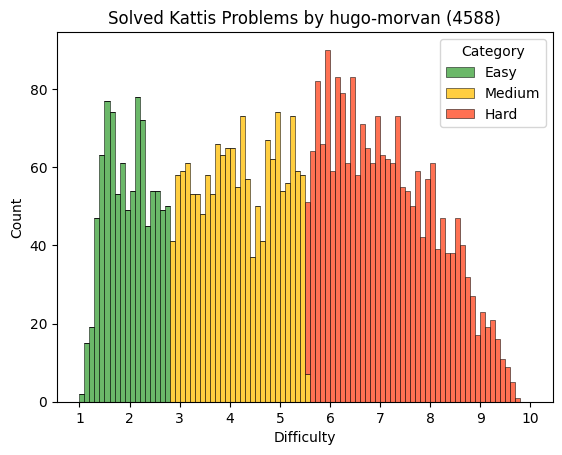

In [2]:
kt.plot_problems(show_partial=True, show_solved=True, show_tried=True, show_untried=True)

In [10]:
#Fetching all solved the problems available on the website.
problems = kt.problems(low_detail_mode=False, show_tried=True, show_untried=True) 
print(type(problems))
print(len(problems))

<class 'autokattis.api.ABCKattis.Result'>
4588


In [ ]:
df = pd.DataFrame(problems)
df.head(5)

,name,id,fastest,shortest,total,acc,difficulty,category,link
0,10 Kinds of People,10kindsofpeople,0.01,368,39937,7656,4.5,Medium,https://open.kattis.com/problems/10kindsofpeople
1,1-D Frogger (Easy),1dfroggereasy,0.00,150,10376,2029,3.2,Medium,https://open.kattis.com/problems/1dfroggereasy
2,1-D Frogger (Hard),1dfroggerhard,0.03,472,5284,477,8.1,Hard,https://open.kattis.com/problems/1dfroggerhard
3,1's For All,1sforall,0.00,5,3277,621,6.2,Hard,https://open.kattis.com/problems/1sforall
4,2048,2048,0.00,5,17428,7105,2.9,Medium,https://open.kattis.com/problems/2048


### Selection of problems for evaluation

Because trying to solve all the problems available is not feasible, we select a representative sample of problems to test the different LLM on. Ideally, the selected problems should match the distribution of problem difficulty of the whole dataset.

In [12]:
sampled_df = df.sample(n=100)

<Figure size 1500x1000 with 0 Axes>

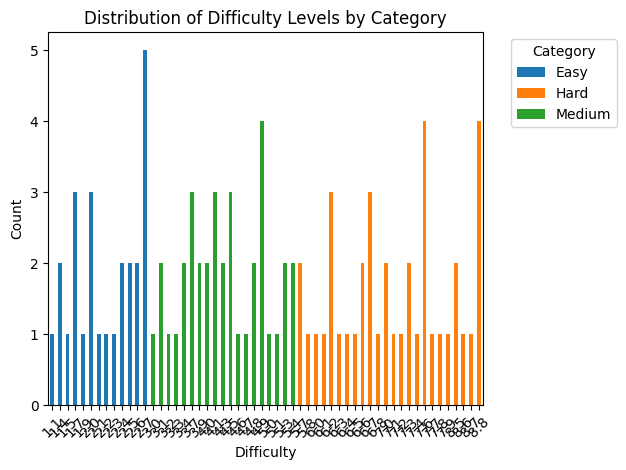

In [21]:
color_map = {'Easy': 'green','Medium': 'yellow','Hard': 'red'}
plt.figure(figsize=(15, 10))
sampled_df.groupby(['difficulty', 'category']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Difficulty Levels by Category')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The plot shows a good spread in the problem difficulty selected, however the sample size is too small to have a true representative distribution. We can now use the problem IDs to extract the problems descriptions from the same API using another function of the autokattis package.

In [22]:
# Extract problem IDs from the sampled DataFrame
problem_ids = sampled_df['id'].tolist()

# Fetch problem details using kt.problem()
problem_details = kt.problem(problem_ids)

# Extract specific details you're interested in
problem_details_extracted = []
for problem in problem_details:
    problem_details_extracted.append({
        'id': problem['id'],
        'text': problem['text'],
        'difficulty': problem.get('difficulty'),
        'category': problem.get('category'),
        'cpu_time': problem.get('cpu'),
        'memory_limit': problem.get('memory'),
        'sample_input': problem['files'].get('sample.in', '') if 'files' in problem else '',
        'sample_output': problem['files'].get('sample.ans', '') if 'files' in problem else ''
    })

# Convert to DataFrame
problem_info_df = pd.DataFrame(problem_details_extracted)

# Merge with original sampled DataFrame
combined_df = sampled_df.merge(problem_info_df, on='id')

In [23]:
combined_df.head()

,name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
0,Emoticons,emoticons2,0.00,251,592,170,4.6,Medium,https://open.kattis.com/problems/emoticons2,Emma is a college student who regularly posts ...,4.6,Medium,3 seconds,1024 MB,,
1,Association for Control Over Minds,control,0.02,159,4501,1420,4.3,Medium,https://open.kattis.com/problems/control,You are the boss of ACM\n (Association for ...,4.3,Medium,4 seconds,1024 MB,,
2,Snapper Chain (Easy),snappereasy,0.00,5,1905,935,2.6,Easy,https://open.kattis.com/problems/snappereasy,Note that this is an easier version of the pro...,2.6,Easy,1 second,1024 MB,,
3,Frosh Week,froshweek2,0.01,5,3437,1772,2.2,Easy,https://open.kattis.com/problems/froshweek2,Professor Zac is trying to finish a collection...,2.2,Easy,3 seconds,1024 MB,,
4,99 Problems,99problems2,0.11,231,5511,4897,4.5,Medium,https://open.kattis.com/problems/99problems2,You’re creating problems for competitive\n ...,4.5,Medium,1 second,1024 MB,,


Checkpoint: saving the data to csv then reloading it. avoids running all the above when reloading the notebook.

In [24]:
combined_df.to_csv('data.csv', index=False)


In [27]:
combined_df = pd.read_csv('data.csv')
combined_df.head(5)

,name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
0,Emoticons,emoticons2,0.00,251,592,170,4.6,Medium,https://open.kattis.com/problems/emoticons2,Emma is a college student who regularly posts ...,4.6,Medium,3 seconds,1024 MB,NaN,NaN
1,Association for Control Over Minds,control,0.02,159,4501,1420,4.3,Medium,https://open.kattis.com/problems/control,You are the boss of ACM\n (Association for ...,4.3,Medium,4 seconds,1024 MB,NaN,NaN
2,Snapper Chain (Easy),snappereasy,0.00,5,1905,935,2.6,Easy,https://open.kattis.com/problems/snappereasy,Note that this is an easier version of the pro...,2.6,Easy,1 second,1024 MB,NaN,NaN
3,Frosh Week,froshweek2,0.01,5,3437,1772,2.2,Easy,https://open.kattis.com/problems/froshweek2,Professor Zac is trying to finish a collection...,2.2,Easy,3 seconds,1024 MB,NaN,NaN
4,99 Problems,99problems2,0.11,231,5511,4897,4.5,Medium,https://open.kattis.com/problems/99problems2,You’re creating problems for competitive\n ...,4.5,Medium,1 second,1024 MB,NaN,NaN


Some data cleaning is needed to extract problem descriptions,  expected input format, expected output format, and sample test cases. Here is a function to do just that:

In [60]:
def parse_desc(raw_text):
    """
    Given the raw text descitpion from the autokattis api response,
    return description, input_rec, output_rec, test_cases_tuples
    
    """
    splitted = raw_text.split('\n')
    input_index = splitted.index('Input')
    output_index = splitted.index('Output')
    test1 = splitted.index('Sample Input 1')
    
    description = " ".join([chunk.strip("   ") for chunk in splitted[0:input_index]])
    #print(f"{description=}")
    input_rec = " ".join([chunk.strip("   ") for chunk in splitted[input_index+1:output_index]])
    #print(f"{input_rec=}")
    output_rec = " ".join([chunk.strip("   ") for chunk in splitted[output_index+1:test1]])
    #print(f"{output_rec=}")
    test_cases = " ".join(splitted[test1:])
    cleaned_test_cases = []
    for s in test_cases.split("    "):
        if "Sample" in s :
            pass
        else:
            cleaned_test_cases.append(s)
    test_cases_tuples = []
    for i in range(len(cleaned_test_cases)):
        if i%2==0:
            test_cases_tuples.append((cleaned_test_cases[i], cleaned_test_cases[i+1]))
    #print(f"{test_cases_tuples=}")
    return description, input_rec, output_rec, test_cases_tuples

# Testing the function:
description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][3])
print(f"{description=}")
print(f"{input_rec=}")
print(f"{output_rec=}")
print(f"{test_cases_tuples=}")

description='Professor Zac is trying to finish a collection of tasks during the first week at the start of the term. He knows precisely how long each task will take, down to the millisecond. Unfortunately, it is also Frosh Week. Zac’s office window has a clear view of the stage where loud music is played. He cannot focus on any task when music is blaring. The event organizers are also very precise. They supply Zac with intervals of time when music will not be playing. These intervals are specified by their start and end times down to the millisecond. Each task that Zac completes must be completed in one quiet interval. He cannot pause working on a task when music plays (he loses his train of thought). Interstingly, the lengths of the tasks and quiet intervals are such that it is impossible to finish more than one task per quiet interval! Given a list of times $t_ i$ (in milliseconds) that each task will take and a list of times $\\ell _ j$ (in milliseconds) specifying the lengths of th

# 2 Model evaluation

Need to create a custom evaluation for the model based on different levels of quality of the code produce by the LLM.
- Level 1: The code is written in the desired language (python) and compile without error.
- Level 2: The code can run on the test input/output without errors
- Level 3: The code succesfully solves the problem on the given sample input/output
- Level 4: The code can run on the hidden input/output withour errors
- Level 5: The code succesfully solves the hidden test cases.

Idea for evaluation: attribute points based on how many level a code generated passes. aggregate the results and rank the LLM accordingly.
To save on calculation, only evaluate level N if N-1 is validated (i.e don't bombard Kattis with non-working code. test Locally prior to testing online)

Needed : 
- A systematic method of evaluating each level. Already exists for level 5.
-> exec("code generated with {input}"), assert result = {output}


### Level 1 check: Does the code compile ?

In case of error, the type of error should be saved for statistics purposes.

In [63]:
import ast
import sys
import io
import contextlib

def check_code_compilation(code_string):
    """
    Check if the given Python code compiles without syntax errors.
    
    Args:
        code_string (str): The Python code to check for compilation
    
    Returns:
        tuple: (is_compilable, error_message)
            - is_compilable (bool): True if code compiles, False otherwise
            - error_message (str): Description of any compilation error
    """
    try:
        # First, check syntax using ast module
        ast.parse(code_string)
        
        # Redirect stderr to capture any compilation warnings
        error_output = io.StringIO()
        with contextlib.redirect_stderr(error_output):
            # Compile the code
            compiled_code = compile(code_string, '<string>', 'exec')
        
        # Check if compilation was successful
        return True, ""
    
    except SyntaxError as e:
        # Detailed syntax error reporting
        error_msg = (
            f"Syntax Error: {e.msg}\n"
            f"Line {e.lineno}, Column {e.offset}\n"
            f"Text: {e.text.strip() if e.text else 'N/A'}"
        )
        return False, error_msg
    
    except Exception as e:
        # Catch any other unexpected compilation errors
        return False, str(e)

# Example usage
def test_code_compilation():
    # Test cases
    test_cases = [
        # Compilable code
        """
def hello_world():
    print("Hello, World!")
""",
        # Code with syntax error
        """
def hello_world()
    print("Hello, World!")
""",
        # Code with indentation error
        """
def hello_world():
print("Hello, World!")
"""
    ]
    
    for code in test_cases:
        is_compilable, error_message = check_code_compilation(code)
        print(f"Code:\n{code}")
        print(f"Compilable: {is_compilable}")
        if not is_compilable:
            print(f"Error: {error_message}")
        print("-" * 40)

# Uncomment to run tests
test_code_compilation()

Code:

def hello_world():
    print("Hello, World!")

Compilable: True
----------------------------------------
Code:

def hello_world()
    print("Hello, World!")

Compilable: False
Error: Syntax Error: expected ':'
Line 2, Column 18
Text: def hello_world()
----------------------------------------
Code:

def hello_world():
print("Hello, World!")

Compilable: False
Error: Syntax Error: expected an indented block after function definition on line 2
Line 3, Column 1
Text: print("Hello, World!")
----------------------------------------


### Level 2 and 3 and check: does the code run on test cases ?

If yes, give some points. Half of problem difficulty ?
In case of error, the type of error should be saved for statistics purposes.

In [18]:
import sys
from io import StringIO
import builtins
from typing import Tuple, Optional, Union

def test_code_output(code_str: str, input_str: str, expected_output: str) -> \
    Tuple[bool, Optional[Union[str, Exception]]]:
    """
    Tests if running the provided code with given input produces the expected output.
    
    Args:
        code_str (str): The Python code to test as a string
        input_str (str): The input to provide to the code
        expected_output (str): The expected output to compare against
    
    Returns:
        Tuple[bool, Optional[Union[str, Exception]]]: 
            - First element is True if execution was successful and output matches, False otherwise
            - Second element contains:
                - None if everything is correct
                - Exception object if there was an execution error
                - String with actual output if output doesn't match expected output
    
    Example:
        code = '''
        n = int(input())
        print(n * 2)
        '''
        success, error = test_code_output(code, "5", "10")  # Returns (True, None)
    """
    # Create StringIO object for output
    output_buffer = StringIO()
    
    # Store the original stdout and input function
    original_stdout = sys.stdout
    original_input = builtins.input
    
    # Create an iterator of input lines
    input_lines = iter(input_str.splitlines())
    
    # Define mock input function
    def mock_input(*args):
        try:
            return next(input_lines)
        except StopIteration:
            raise EOFError("No more input available")
    
    try:
        # Redirect stdout and override input
        sys.stdout = output_buffer
        builtins.input = mock_input
        
        # Execute the code in a separate namespace
        namespace = {'__name__': '__main__'}
        exec(code_str, namespace)
        
        # Get the actual output and strip whitespace
        actual_output = output_buffer.getvalue().strip()
        expected_output = expected_output.strip()
        
        # Compare actual output with expected output
        if actual_output == expected_output:
            return True, None
        else:
            return False, f"WrongOutput(Expected: '{expected_output}'\nGot: '{actual_output}')"
        
    except Exception as e:
        return False, e
        
    finally:
        # Restore original stdout and input function
        sys.stdout = original_stdout
        builtins.input = original_input
        output_buffer.close()

In [20]:
# Example 1: Testing a simple doubling program
code = """
n = int(input())
print(n * 2)
"""
result = test_code_output(code, "5", "10")
print(result)  # True

# Example 2: Testing a program with incorrect output
result = test_code_output(code, "5", "11")
print(result)  # False

# Example 3: Testing a program with multiple inputs
code_multiple = """
a = input()
b = input(
print(a + b)
"""
result = test_code_output(code_multiple, "hello\nworld", "helloworld")
print(result)  # True

(True, None)
(False, "WrongOutput(Expected: '11'\nGot: '10')")
(False, SyntaxError("'(' was never closed", ('<string>', 3, 10, 'b = input(', 3, 0)))


### Level 4 and 5 and check: does the code run on test cases ?

Here we need to submit the code to the kattis website to know if the code produced passes the hidden test cases.
The Kattis CLI tool is used to do that. Only the codes that passes the level 3 should be submitted to the katti website. In case of error, the type of error should be saved for statistics purposes.

In [ ]:
from submit import *
from utils import *

#Write solution to a python file
write_solution(file_path, code)
#submit the solution to the kattis website
submit_problem(file_path , pid)

# 3 LLM Prompting

Need to create a prompt that give the description as well as sample input output to the LLM. 
Can try different methods:
- description only
- description + sample input/output
- language LLM
- Code specific LLM
- Language to Code LLM pipeline
- Different quantization methods, 
- Different model sizes.


In [33]:
#Define the different models.
generators = [0]

In [ ]:
# Connect to a kattis account

In [ ]:
#Generate code from the different model (generators), and test it.

for generator in generators:
    print(generator) #Print the name of the generator.
    generator_name = generator.name()
    # Needs some statistics gathering here
    # initialize for each generator, maybe append to a stat dataframe.
    # ideas for stat: Number of level 1,2,3,4,5 passes,
    # which difficulty, 
    # Type of errors
    # time taken (for code generation)
    
    for problem in range(len(combined_df)):
        #print(problem)
        #name,id,fastest,shortest,total,acc,difficulty_x,category_x,link,text,
        #difficulty_y,category_y,cpu_time,memory_limit,sample_input,sample_output
        #print(combined_df['id'][problem])
        pid = combined_df['id'][problem]
        #continue
        #Get the problem description, IO reqs, test IOs
        description, input_rec, output_rec, test_cases_tuples = parse_desc(combined_df['text'][problem])
        input_str, expected_output = test_cases_tuples
        #build the prompt
        
        # generate code using generator and prompt
        start_time = ...
        raw_output = generator.generate_solution(description)
        end_time = ...
        # Add delta time to statistics board.
        code = extract_code(raw_output)
        # write the code to a file, in a folder specific to the generator.
        file_path = generator_name+ '/' + pid + '.py'
        write_solution(file_path, code)
        
        # Test the different level:
        
        # Level 1: Code compiles:
        level1 = check_code_compilation(code)
        # If the code does not pass level 1, continue to next problem (saves computation)
        if not level1: continue
        
        # Level 2, 3: Code run and solve test IO
        lvl2_list = []
        lvl3_list = []
        for test_case in range(len(input_str)):
            test_res, errors = test_code_output(code, input_str[test_case], expected_output[test_case])
            if test_res: #Code sucessfully passed level 2 and 3
                lvl2_list.append(True)
                lvl3_list.append(True)
            else: #Code did not run successfully, is error level 2 (run time error) or level 3 (wrong output)
                if "WrongOutput" in errors: #level 3 error
                    lvl2_list.append(True)
                    lvl3_list.append(False)
                else: #Run time error
                    lvl2_list.append(False)
                    lvl3_list.append(False)
                    
        # Did the code run without error on all the test cases?
        level2 = all(lvl2_list)
        # Did the code pass all the test cases ? 
        level3 = all(lvl3_list)
        
        # If the code does not pass level 3, continue to next problem (saves computation)
        if not level3: continue
        
        # Level 4, 5: Code run and solve hidden IO (Only run if level 3 passes)
        
        kattis_response = submit_problem(file_path, pid)
        if "Accepted" in kattis_response:
            level4 = True
            level5 = True
        elif "Wrong Answer" in kattis_response:
            level4 = True
            level5 = False
        else:
            level4 = False
            level5 = False
            # obtain the type of error for statistics
        
        # Output problem level statistics
    # Aggregate and output generator level statistics
    
# Done      

## Results

After all this work, here comes the results:

TBD